In [162]:
from mlflow.tracking import MlflowClient
import mlflow
import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from scenario_utils.scenarios import Scenarios_Client
import forecast_utils as utils

# Set the tracking URI to the directory where mlruns is located
tracking_uri = "file:///Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/mlruns"
mlflow.set_tracking_uri(tracking_uri)

client = MlflowClient()

pd.options.display.max_columns = 1000

## Loading mlflow Models:

In [163]:
# Loading Monthly Model.
model_name = "gb_non_dom_monthly"
model = client.get_registered_model(model_name)
monthly_model = mlflow.pyfunc.load_model(f"models:/{model.name}/{list(model.aliases.values())[0]}")

# Loading Daily Model.
model_name = "gb_non_dom_daily"
model = client.get_registered_model(model_name)
daily_model = mlflow.pyfunc.load_model(f"models:/{model.name}/{list(model.aliases.values())[0]}")

## Making Scenarios' Inputs

In [188]:
### Daily Regressor Scenarios:

# Getting variables
temperature = utils.make_daily_regressors_df(initial_date='2015-01-01')[1]
temperature = temperature[temperature['ds'] < '2031-04-01']
cdd = temperature[['ds', 'cdd']].copy()
hdd = temperature[['ds', 'hdd']].copy()
temperature = temperature[['ds', 'temperature']]

# Temperature:
col = 'temperature'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = temperature[temperature['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(temperature) - index_plus
weather_factors = []

for x in range(20):
  temperature.loc[:index, col+'_'+str(x+1)] = temperature.loc[:index, 'temperature'].copy()
  random_factors = np.array([np.random.normal(loc=1, scale=max_std_dev * (i/remaining)) for i in range(remaining)])
  weather_factors.append(random_factors)
  temperature.loc[index_plus:, col+'_'+str(x+1)] = temperature.loc[index_plus:, 'temperature'].values * random_factors

temperature = temperature.drop(columns=col)

# Heating Degree Days:
col = 'hdd'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = hdd[hdd['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(hdd) - index_plus

for x in range(20):
  hdd.loc[:index, col+'_'+str(x+1)] = hdd.loc[:index, 'hdd'].copy()
  hdd.loc[index_plus:, col+'_'+str(x+1)] = hdd.loc[index_plus:, 'hdd'].values * weather_factors[x]

hdd = hdd.drop(columns=col)

# Cooling Degree Days:
col = 'cdd'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = cdd[cdd['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(cdd) - index_plus

for x in range(20):
  cdd.loc[:index, col+'_'+str(x+1)] = cdd.loc[:index, 'cdd'].copy()
  cdd.loc[index_plus:, col+'_'+str(x+1)] = cdd.loc[index_plus:, 'cdd'].values * weather_factors[x]

cdd = cdd.drop(columns=col)

In [189]:
# Monthly Regressor Scenarios:

gdp = pd.read_parquet("data/regressors/gdp.parquet")
col = 'gdp'
max_std_dev = 0.01  # Adjust this to control the initial variance
index = gdp[gdp['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(gdp) - index_plus

for x in range(20):
  gdp.loc[:index, col+'_'+str(x+1)] = gdp.loc[:index, 'gdp'].copy()
  random_factors = np.array([np.random.normal(loc=1, scale=max_std_dev * (i/remaining)) for i in range(remaining)])
  gdp.loc[index_plus:, col+'_'+str(x+1)] = gdp.loc[index_plus:, 'gdp'].values * random_factors

gdp = gdp.drop(columns=col)

# Working using the Scenarios_Client Object

In [190]:
scenarios = Scenarios_Client(granular_model=daily_model, monthly_model=monthly_model, mlflow_uri=tracking_uri)

In [191]:
scenarios.add_variable(variable_df=gdp, variable_name='gdp')
scenarios.add_variable(variable_df=temperature, variable_name='temperature')
scenarios.add_variable(variable_df=hdd, variable_name='hdd')
scenarios.add_variable(variable_df=cdd, variable_name='cdd')

'Added cdd'

In [192]:
scenarios.variables_pairing(variables=['temperature', 'hdd', 'cdd'])

"Paired variables: ['temperature', 'hdd', 'cdd']"

In [193]:
scenarios_df = scenarios.create_scenarios()

In [194]:
scenarios.variables_granularities

{'1day', '1month'}

In [198]:
scenarios_df[399]['1day'], scenarios_df[399]['1month']

(             ds  temperature_20       hdd_20  cdd_20
 0    2015-01-01        9.994652   803.921260     0.0
 1    2015-01-02        6.967103  1949.742425     0.0
 2    2015-01-03        4.495221  2882.854784     0.0
 3    2015-01-04        1.930792  3866.575854     0.0
 4    2015-01-05        6.817229  1990.184090     0.0
 ...         ...             ...          ...     ...
 5929 2031-03-27       10.923510  3632.624844     0.0
 5930 2031-03-28        6.458472  1777.648126     0.0
 5931 2031-03-29        4.966899  1463.642875     0.0
 5932 2031-03-30        0.089799    29.537610     0.0
 5933 2031-03-31        7.753096  2824.813684     0.0
 
 [5934 rows x 4 columns],
             ds      gdp_20
 0   2015-01-01   91.687000
 1   2015-02-01   91.961000
 2   2015-03-01   92.019500
 3   2015-04-01   92.551300
 4   2015-05-01   92.306600
 ..         ...         ...
 190 2030-11-01  115.990440
 191 2030-12-01  115.915689
 192 2031-01-01  116.493868
 193 2031-02-01  115.436507
 194 2031-03-01 

In [222]:
scenarios_df[0]['1day']

,ds,temperature_1,hdd_1,cdd_1
0,2015-01-01,9.994652,803.921260,0.0
1,2015-01-02,6.967103,1949.742425,0.0
2,2015-01-03,4.495221,2882.854784,0.0
3,2015-01-04,1.930792,3866.575854,0.0
4,2015-01-05,6.817229,1990.184090,0.0
...,...,...,...,...
5929,2031-03-27,9.381489,3119.824182,0.0
5930,2031-03-28,7.120822,1959.955450,0.0
5931,2031-03-29,7.073823,2084.510012,0.0
5932,2031-03-30,7.476978,2459.400069,0.0


## Example for implementation into Scenarios Object

In [233]:
### Granular Thingies:

## Putting the Granular scenario variables into the "Future DF"

# Getting the variables' ordered names:
granular_scenario_variables_ordered_list = []
granular_granularity = [x for x in list(scenarios.variables_granularities) if x != '1month'][0]
for var in scenarios.variables.keys():
  if scenarios.variables[var]["granularity"] == granular_granularity:
    granular_scenario_variables_ordered_list.append(var)

# Getting the scenario NUMBER 0 regressors and changing the col names to the ordered variable names (from temperature_1 to temperature for example)
gran_regs_df = scenarios_df[0][granular_granularity].copy()
scen_cols = [x for x in gran_regs_df.columns if x != 'ds']
gran_regs_df = gran_regs_df.rename(columns=dict(zip(scen_cols, granular_scenario_variables_ordered_list)))

# Creating the future_df and replacing the "default variables" for the new values from the scenario
future_df = utils.make_forecast_df(granularity='D', category='Non-domestic', forecast_date='2031-04-01').drop(columns=granular_scenario_variables_ordered_list)
future_df = future_df.merge(gran_regs_df, how='left', on='ds').dropna()

# Forecasting the future_df and getting the "weather_bh_corrected distribution" to add onto the monthly model.
simple_fc = scenarios.granular_model.predict(future_df)
scenarios.granular_model.granularity = 'D'
granular_df = utils.full_forecast_df(model=scenarios.granular_model, future=future_df, forecast=simple_fc)
aux_granular = granular_df.copy()
granular_df['year_month'] = granular_df['ds'].dt.to_period("M").astype(str)
granular_df['year_month'] = pd.to_datetime(granular_df['year_month'], format="%Y-%m")
granular_df['weather_bh_terms'] = granular_df[['temperature', 'cdd', 'hdd', 'holidays']].sum(axis=1) - granular_df[[x for x in granular_df.columns.tolist() if 'lockdown' in x]].sum(axis=1)
granular_df['corrected_multiplicative_terms'] = 1 + (granular_df['multiplicative_terms'] - granular_df['weather_bh_terms'])
granular_df['normal_multiplicative_terms'] = 1 + granular_df['multiplicative_terms']
granular_df['yhat_wc_bh'] = granular_df['trend'] * granular_df['corrected_multiplicative_terms']
granular_df['yhat_real_proportion'] = granular_df.groupby('year_month')['corrected_multiplicative_terms'].transform(lambda x: x.sum())
granular_df['yhat_real_proportion'] = granular_df['normal_multiplicative_terms']/granular_df['yhat_real_proportion']
granular_df.columns = "granular_" + granular_df.columns

# Getting the columns we are interested in:
regressors = []
for reg in granular_scenario_variables_ordered_list:
  regressors.append("granular_"+reg)
  regressors.append("granular_nominal_"+reg)
granular_df = granular_df.rename(columns={"granular_year_month" : 'monthly_ds'})
granular_df = granular_df[['granular_ds', 'monthly_ds', 'granular_yhat_real_proportion', *regressors]]

In [237]:
## Monthly Thingies:

## Putting the Monthly scenario variables into the "Future DF"

# Getting the variables' ordered names:
monthly_model_scenario_variables_ordered_list = []
monthly_granularity = '1month'
for var in scenarios.variables.keys():
  if scenarios.variables[var]["granularity"] == monthly_granularity:
    monthly_model_scenario_variables_ordered_list.append(var)

# Getting the scenario NUMBER 0 regressors and changing the col names to the ordered variable names (from gdp_1 to gdp for example)
gran_regs_df = scenarios_df[0][monthly_granularity].copy()
scen_cols = [x for x in gran_regs_df.columns if x != 'ds']
gran_regs_df = gran_regs_df.rename(columns=dict(zip(scen_cols, monthly_model_scenario_variables_ordered_list)))

# Creating the future_df and replacing the "default variables" for the new values from the scenario
future_df = utils.make_forecast_df(granularity='M', category='Non-domestic', forecast_date='2031-03-01').drop(columns=monthly_model_scenario_variables_ordered_list)
future_df = future_df.merge(gran_regs_df, how='left', on='ds').dropna()

# Forecasting the future_df and getting the macro scenarios.
simple_fc = scenarios.monthly_model.predict(future_df)
scenarios.monthly_model.granularity = 'M'
monthly_df = utils.full_forecast_df(model=scenarios.monthly_model, future=future_df, forecast=simple_fc)
aux_monthly = monthly_df.copy()
monthly_df = monthly_df.rename(columns={'ds' : 'monthly_ds'})

# Getting the columns we are interested in:
regressors = []
for reg in monthly_model_scenario_variables_ordered_list:
  regressors.append(reg)
  regressors.append("nominal_"+reg)

monthly_df = monthly_df[['monthly_ds', 'yhat', *regressors]]

/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:165: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['abnormal'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:167: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['covid_1'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:169: FutureWarning: The behavior of 'isin' with dtype=datetim

In [243]:
## Final Thingies:
df = granular_df.merge(monthly_df, how='left', on='monthly_ds')
df['scenario_yhat'] = df['yhat'] * df['granular_yhat_real_proportion']
df = df.drop(columns=['yhat', 'granular_yhat_real_proportion', 'monthly_ds'])

## Iterations

In [249]:
modelling = {}

for scenario_num in range(len(scenarios_df)):

  ### Granular Thingies:

  ## Putting the Granular scenario variables into the "Future DF"

  # Getting the variables' ordered names:
  granular_scenario_variables_ordered_list = []
  granular_granularity = [x for x in list(scenarios.variables_granularities) if x != '1month'][0]
  for var in scenarios.variables.keys():
    if scenarios.variables[var]["granularity"] == granular_granularity:
      granular_scenario_variables_ordered_list.append(var)

  # Getting the scenario NUMBER 0 regressors and changing the col names to the ordered variable names (from temperature_1 to temperature for example)
  gran_regs_df = scenarios_df[scenario_num][granular_granularity].copy()
  scen_cols = [x for x in gran_regs_df.columns if x != 'ds']
  gran_regs_df = gran_regs_df.rename(columns=dict(zip(scen_cols, granular_scenario_variables_ordered_list)))

  # Creating the future_df and replacing the "default variables" for the new values from the scenario
  future_df = utils.make_forecast_df(granularity='D', category='Non-domestic', forecast_date='2031-04-01').drop(columns=granular_scenario_variables_ordered_list)
  future_df = future_df.merge(gran_regs_df, how='left', on='ds').dropna()

  # Forecasting the future_df and getting the "weather_bh_corrected distribution" to add onto the monthly model.
  simple_fc = scenarios.granular_model.predict(future_df)
  scenarios.granular_model.granularity = 'D'
  granular_df = utils.full_forecast_df(model=scenarios.granular_model, future=future_df, forecast=simple_fc)
  aux_granular = granular_df.copy()
  granular_df['year_month'] = granular_df['ds'].dt.to_period("M").astype(str)
  granular_df['year_month'] = pd.to_datetime(granular_df['year_month'], format="%Y-%m")
  granular_df['weather_bh_terms'] = granular_df[['temperature', 'cdd', 'hdd', 'holidays']].sum(axis=1) - granular_df[[x for x in granular_df.columns.tolist() if 'lockdown' in x]].sum(axis=1)
  granular_df['corrected_multiplicative_terms'] = 1 + (granular_df['multiplicative_terms'] - granular_df['weather_bh_terms'])
  granular_df['normal_multiplicative_terms'] = 1 + granular_df['multiplicative_terms']
  granular_df['yhat_wc_bh'] = granular_df['trend'] * granular_df['corrected_multiplicative_terms']
  granular_df['yhat_real_proportion'] = granular_df.groupby('year_month')['corrected_multiplicative_terms'].transform(lambda x: x.sum())
  granular_df['yhat_real_proportion'] = granular_df['normal_multiplicative_terms']/granular_df['yhat_real_proportion']
  granular_df.columns = "granular_" + granular_df.columns

  # Getting the columns we are interested in:
  regressors = []
  for reg in granular_scenario_variables_ordered_list:
    regressors.append("granular_"+reg)
    regressors.append("granular_nominal_"+reg)
  granular_df = granular_df.rename(columns={"granular_year_month" : 'monthly_ds'})
  granular_df = granular_df[['granular_ds', 'monthly_ds', 'granular_yhat_real_proportion', *regressors]]

  ## Monthly Thingies:

  ## Putting the Monthly scenario variables into the "Future DF"

  # Getting the variables' ordered names:
  monthly_model_scenario_variables_ordered_list = []
  monthly_granularity = '1month'
  for var in scenarios.variables.keys():
    if scenarios.variables[var]["granularity"] == monthly_granularity:
      monthly_model_scenario_variables_ordered_list.append(var)

  # Getting the scenario NUMBER 0 regressors and changing the col names to the ordered variable names (from gdp_1 to gdp for example)
  gran_regs_df = scenarios_df[scenario_num][monthly_granularity].copy()
  scen_cols = [x for x in gran_regs_df.columns if x != 'ds']
  gran_regs_df = gran_regs_df.rename(columns=dict(zip(scen_cols, monthly_model_scenario_variables_ordered_list)))

  # Creating the future_df and replacing the "default variables" for the new values from the scenario
  future_df = utils.make_forecast_df(granularity='M', category='Non-domestic', forecast_date='2031-03-01').drop(columns=monthly_model_scenario_variables_ordered_list)
  future_df = future_df.merge(gran_regs_df, how='left', on='ds').dropna()

  # Forecasting the future_df and getting the macro scenarios.
  simple_fc = scenarios.monthly_model.predict(future_df)
  scenarios.monthly_model.granularity = 'M'
  monthly_df = utils.full_forecast_df(model=scenarios.monthly_model, future=future_df, forecast=simple_fc)
  aux_monthly = monthly_df.copy()
  monthly_df = monthly_df.rename(columns={'ds' : 'monthly_ds'})

  # Getting the columns we are interested in:
  regressors = []
  for reg in monthly_model_scenario_variables_ordered_list:
    regressors.append(reg)
    regressors.append("nominal_"+reg)

  monthly_df = monthly_df[['monthly_ds', 'yhat', *regressors]]

  ## Final Thingies:
  df = granular_df.merge(monthly_df, how='left', on='monthly_ds')
  df['scenario_yhat'] = df['yhat'] * df['granular_yhat_real_proportion']
  df = df.drop(columns=['yhat', 'granular_yhat_real_proportion', 'monthly_ds'])

  modelling[scenario_num] = df.copy()

/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:165: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['abnormal'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:167: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['covid_1'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:169: FutureWarning: The behavior of 'isin' with dtype=datetim

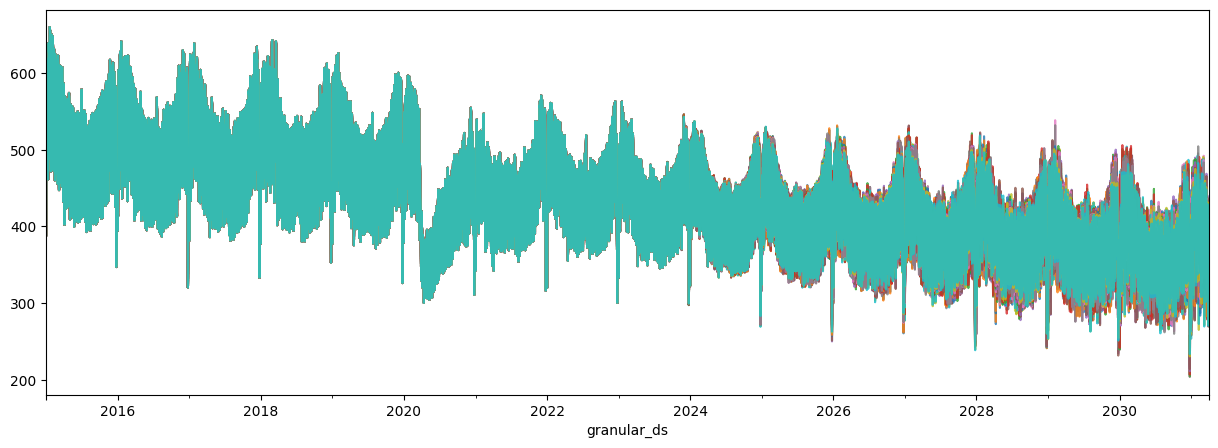

In [257]:
for x in [x*10 for x in range(40)]:
  modelling[x].set_index('granular_ds')['scenario_yhat'].plot(figsize=(15,5), alpha=0.8)

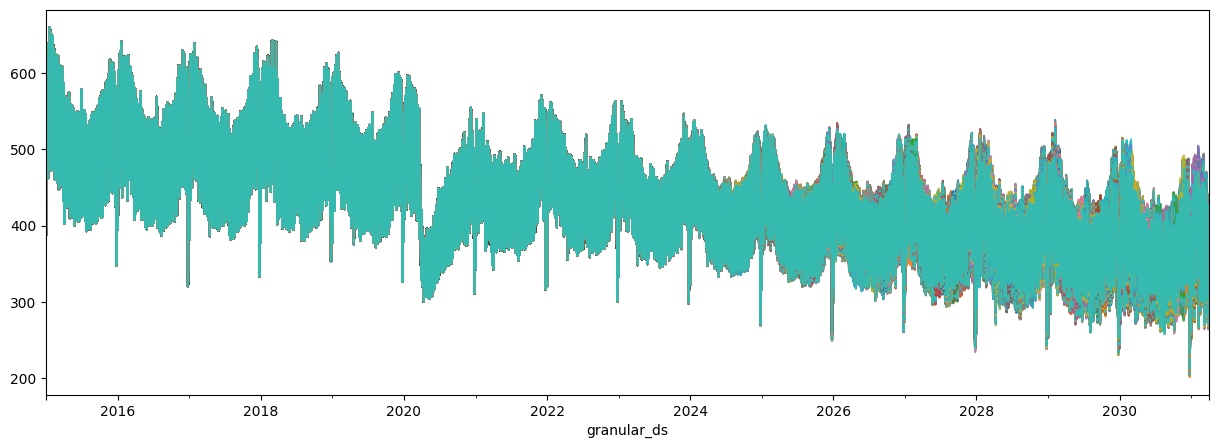

In [259]:
for x in range(400):
  modelling[x].set_index('granular_ds')['scenario_yhat'].plot(figsize=(15,5), alpha=0.8)

In [258]:
import pickle

with open("scenarios.pkl", 'wb') as f:
  pickle.dump(modelling, f)

In [266]:
df = pd.DataFrame()

for aux in modelling:
  aux_df = modelling[aux].copy()
  aux_df['scenario_num'] = aux + 1
  df = pd.concat([df, aux_df])

In [280]:
import datetime
now = datetime.datetime.today().strftime(format="%Y_%m_%d_%H_%M_%S_")

df.to_parquet(f"scenario_outputs/{now}scenarios.parquet")